In [1]:
import time
start_time=time.time()

In [2]:
#import sys
#from pathlib import Path
import json
import numpy as np
#import strucfunc
import matplotlib.pyplot as plt
import time
#from astropy.io import fits
import pandas as pd
import seaborn as sns
#import math
#import sys
#import os
#from sabreMod import sosf,sosfh
#from scipy import interpolate
#import itertools
import lmfit

In [3]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

In [4]:
def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    seeing = (np.tanh((r / (2.0 * s0)**2)))**2
    return seeing * bfunc00(r, r0, sig2, m)

In [5]:
data = json.load(open("SFdata//604.json"))

pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
s0 = 0.5              # parsec
#s0 = 4.09/2.355                    # parsec
m = 1.7

9.091582872650315

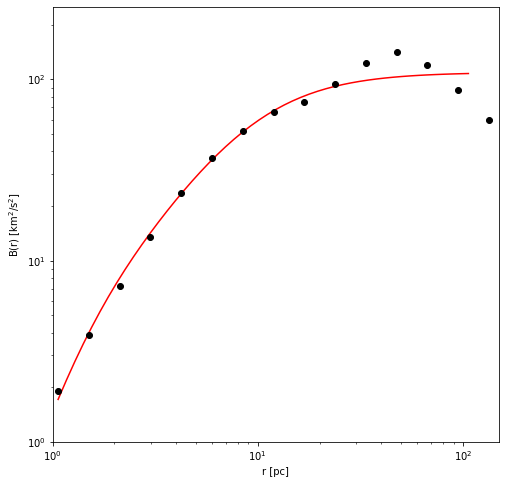

In [6]:
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]

rgrid = pixscale * np.logspace(0.0, 2)
r0 = np.interp(sig2, B, r)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc01(rgrid, r0, sig2, m, s0), color="red")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 250],
    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

r0

In [7]:
model01 = lmfit.Model(bfunc01)
model01.param_names

['r0', 'sig2', 'm', 's0']

In [8]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[-5:] /= 4.0

In [9]:
for p in model01.param_names:
    model01.set_param_hint(p, min=0.0)
model01.print_param_hints()

Name     Value      Min      Max     Vary    Expr    
m          nan        0      inf     True    
r0         nan        0      inf     True    
s0         nan        0      inf     True    
sig2       nan        0      inf     True    


In [10]:
result2 = model01.fit(
    B, 
    weights=weights,
    r=r, r0=r0, sig2=sig2, m=m, s0=s0
)

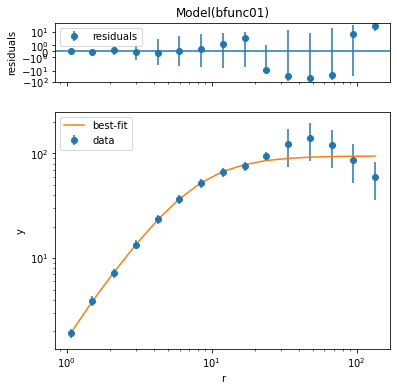

In [11]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);



In [12]:
print(result2.fit_report())

[[Model]]
    Model(bfunc01)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 15
    # variables        = 4
    chi-square         = 4.73762968
    reduced chi-square = 0.43069361
    Akaike info crit   = -9.28769886
    Bayesian info crit = -6.45549805
[[Variables]]
    r0:    7.55728779 +/- 0.60617134 (8.02%) (init = 9.091583)
    sig2:  47.3380106 +/- 2.91555455 (6.16%) (init = 54.62046)
    m:     1.94730858 +/- 0.09452398 (4.85%) (init = 1.7)
    s0:    0.35769634 +/- 0.08604992 (24.06%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2) =  0.906
    C(r0, m)    = -0.890
    C(m, s0)    = -0.778
    C(sig2, m)  = -0.706
    C(r0, s0)   =  0.552
    C(sig2, s0) =  0.439


In [13]:
result2.conf_interval()
print(result2.ci_report())

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0  :  -1.67765  -1.09955  -0.56997   7.55729  +0.68939  +1.68605  +3.51629
 sig2:  -9.29076  -5.82424  -2.86844  47.33801  +3.20174  +7.42508 +14.20627
 m   :  -0.41581  -0.22695  -0.10069   1.94731  +0.08949  +0.17065  +0.27790
 s0  :      -inf      -inf      -inf   0.35770  +0.06482  +0.12213  +0.19822


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 4 and prob(s0=0.013496672344196964) = 0.41069400165605613 < max(sigmas).
  warn(errmsg)


In [14]:
lmxsig2=35
lmnsig2=70
lmxr0=5
lmnr0=13
lmxm=1.2
lmnm=2.4
lmxs0=0.0
lmns0=1.0

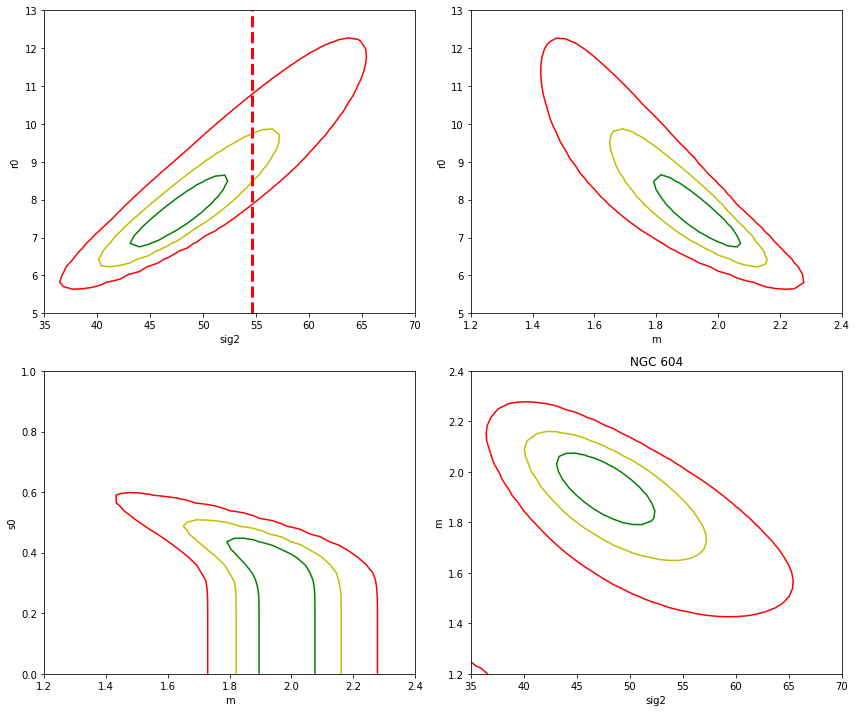

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('NGC 604')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'r0', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnr0, lmxr0]],
)
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]
ctp = axes[0, 0].contour(cx, cy, grid, levels, colors=colors)
axes[0, 0].axvline(result2.init_params["sig2"].value, color="r", lw=3, ls="dashed")
axes[0, 0].set_xlabel('sig2')
axes[0, 0].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 'r0', 40, 40,
    limits=[[lmnm, lmxm], [lmnr0, lmxr0]],
)
ctp = axes[0, 1].contour(cx, cy, grid, levels, colors=colors)
axes[0, 1].set_xlabel('m')
axes[0, 1].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 's0', 40, 40,
    limits=[[lmnm, lmxm], [lmns0, lmxs0]],
)
ctp = axes[1, 0].contour(cx, cy, grid, levels, colors=colors)
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('s0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'm', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnm, lmxm]],
)
ctp = axes[1, 1].contour(cx, cy, grid, levels, colors=colors)
axes[1, 1].set_xlabel('sig2')
axes[1, 1].set_ylabel('m')


fig.tight_layout();

In [16]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 31.222293376922607 seconds ---
